# ***CODE FOR CNNs***
## ***Introduction***
In replicating the [research](https://arxiv.org/abs/2010.11929) presented by Dosovitskiy et al. (2021), our project attempts to adapt and fine-tune the pre-trained Vision Transformer (ViT) model specifically for the Places 365 dataset, a comprehensive image dataset designed for scene recognition tasks. The original paper demonstrated the viability of applying Transformers, traditionally used in natural language processing, directly to image patches for robust image recognition tasks. Our aim is to leverage these large-scale pre-trained models and transfer their learned representations to our specific scene recognition task, hoping to achieve high accuracy in classifying and understanding diverse scene types.

This project will explore the effectiveness of the ViT model, pre-trained on vast datasets like ImageNet-21k and JFT-300M, when fine-tuned for the Places 365 dataset. By adopting this approach, we expect to use the Transformer's strengths in handling varying resolutions and its robustness against overfitting, attributes critical for dealing with comprehensive scene recognition tasks​


## **PRE-TRAINED MODELS UPLOADING**

We encountered challenges in locating the pre-trained BiT-L (ResNet 152x4) model in the [provided repository](https://github.com/google-research/big_transfer/tree/master), so we used a ResNet 152x4 pretrained on ImageNet21k implementation from the `timm` library. This version incorporates Group Normalization and standardized convolution layers, aligning with the modifications described in the BiT paper by Kolesnikov et al. (2020). Similarly, the "Noisy Student" model was unavailable, so we opted for the EfficientNet-B7 variant, pre-trained on JFT-300M, that approximates the one (EfficientNet-B0) from the study by Xie et al. (2020).

#### ***Libraries and dependencies***

In [ ]:
import sys
import torch.nn as nn
import jax
import numpy as np
import os  #directories and other related stuff
import pickle #to save the model
import tensorflow as tf
import timm
import torch, torchvision
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from PIL import Image
#! pip install fvcore
import fvcore
from fvcore.nn import FlopCountAnalysis
#! pip install optuna
import optuna #automatic hyperparameter tuning
from torch.optim import SGD
from transformers import get_cosine_schedule_with_warmup
import optuna
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### ***Customizing the Models for Fine-Tuning***

To fine-tune the models on Places365, we need to adjust the classification head to match the number of classes in the dataset and freeze all layers except the classification head.

For Noisy Student and BiT-L models, the classification head modification and layer freezing must be done manually. Unlike Vision Transformers, these models do not require dividing the input into patches, but additional effort is needed to customize the classification head and freeze the appropriate layers.

We first ***load the models***:

##### ***Noisy Student (EfficientNet-B7)*** approximation from the paper by Xie et al. (2020):

> We decided to approximate EfficienNet L2 with EfficientNet B7 because even though EfficienNet L2 is available in the [Google GitHub repository](https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet) it would require substantial computational resources that are not available.

In [ ]:
# Load pre-trained Noisy Student EfficientNet-B7 model
effnet_model = timm.create_model('tf_efficientnet_b7_ns', pretrained=True)
# Replace the classifier head with a new one
num_classes = 20
effnet_model.classifier = nn.Linear(effnet_model.classifier.in_features, num_classes)

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b7_ns to current tf_efficientnet_b7.ns_jft_in1k.
  model = create_fn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/267M [00:00<?, ?B/s]

##### ***BiT-L (ResNet 152x4)*** approximation from the paper Kolesnikov et al., 2020:

In [ ]:
# Load pre-trained BiT ResNet model
resnet152x4 = timm.create_model('resnetv2_152x4_bit.goog_in21k_ft_in1k', pretrained=True)

# Modify the classifier head for fine-tuning
num_classes = 20
resnet152x4.head = nn.Sequential(
    nn.Conv2d(resnet152x4.head.fc.in_channels, num_classes, kernel_size=(1, 1)),
    nn.Dropout(p=0.1),
    nn.AdaptiveAvgPool2d((1, 1)),  # Global Average Pooling
    nn.Flatten()  # Flatten to (batch_size, num_classes)
)

print("Modified ResNet152x4 model ready for fine-tuning!")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/3.75G [00:00<?, ?B/s]

Modified ResNet152x4 model ready for fine-tuning!


This models are already loaded since timm handles this automatically, so we can go directly to adjust teh classification head and freeze all the layers except for the head.

***For the BiT-L(ResNet 152x4) model***

In [ ]:
# Freeze all layers except the head
for param in resnet152x4.parameters():
    param.requires_grad = False  # Freeze all layers
for param in resnet152x4.head.parameters():
    param.requires_grad = True  # Unfreeze the head

print("Timm ResNet model ready for fine-tuning!")

***For the Noisy Student EfficientNet-B7 model*** <br>

In [ ]:
# Freeze all layers except the head
for param in effnet_model.parameters():
    param.requires_grad = False

# Allow the new classifier head to be trained
for param in effnet_model.classifier.parameters():
    param.requires_grad = True

print("Noisy Student EfficientNet-B7 model ready for fine-tuning!")

Noisy Student EfficientNet-B7 model ready for fine-tuning!


### ***Preparing the dataset***
After configuring the models, we also preprocessed the images to ensure compatibility. Each image was resized to (224*224) pixels to standardize the input dimensions, and the pixel values were normalized using a mean of \([0.485, 0.456, 0.406]\) and a standard deviation of \([0.229, 0.224, 0.225]\). <br> Although these normalization values are standard for ImageNet-trained models, they align well with EfficientNet’s preprocessing requirements.

In [ ]:
# Dataset paths
train_dir = "/content/drive/MyDrive/Dataset/Subsample_20_classes_spliited/subset_only_20_train"
val_dir = "/content/drive/MyDrive/Dataset/Subsample_20_classes_spliited/subset_only_20_val"
test_dir = "/content/drive/MyDrive/Dataset/Subsample_20_classes_spliited/subset_only_20_test"

# Preprocessing transforms
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Load datasets
train_data = datasets.ImageFolder(train_dir, transform=preprocess)
val_data = datasets.ImageFolder(val_dir, transform=preprocess)
test_data = datasets.ImageFolder(test_dir, transform=preprocess)

batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
#Check if the images have the right shapes:

for images, labels in train_loader:
    print("Train Images Shape:", images.shape)  # (batch_size, 3, 224, 224)
    print("Train Labels Shape:", labels.shape)  # (batch_size,)
    break

for images, labels in val_loader:
    print("Validation Images Shape:", images.shape)  # (batch_size, 3, 224, 224)
    print("Validation Labels Shape:", labels.shape)  # (batch_size,)
    break

for images, labels in test_loader:
    print("Test Images Shape:", images.shape)  # (batch_size, 3, 224, 224)
    print("Test Labels Shape:", labels.shape)  # (batch_size,)
    break

#### ***FLOPs***

Then we computed the FLOPs (Floating Point Operations) of the models to evaluate their computational complexity and efficiency. This metric provides insight into the amount of computational effort required for a forward pass, helping us compare the performance and resource demands of different models.<br> It will be used to make an accuracy vs FLOPs graph later.
> For Efficientnet

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
effnet_model.to(device)

for images, _ in test_loader:
    input_tensor = images.to(device)
    break

# FLOPs computation
flops = FlopCountAnalysis(effnet_model, input_tensor)
print(f"Total FLOPs for one forward pass: {flops.total()} FLOPs")

dataset_size = len(train_data)
num_epochs = 10
batch_size = 32

total_flops = (flops.total() * dataset_size * num_epochs) / batch_size
print(f"Total FLOPs for fine-tuning: {total_flops}")

> For ResNet152x4

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet152x4.to(device)

for images, _ in test_loader:
    input_tensor = images.to(device)
    break

# FLOPs computation
flops = FlopCountAnalysis(resnet152x4, input_tensor)
print(f"Total FLOPs for one forward pass: {flops.total()} FLOPs")

dataset_size = len(train_data)
num_epochs = 10
batch_size = 32

total_flops = (flops.total() * dataset_size * num_epochs) / batch_size
print(f"Total FLOPs for fine-tuning: {total_flops}")

Total FLOPs for one forward pass: 2934687926592 FLOPs
Total FLOPs for fine-tuning: 2201015944944000.0


### ***FINE-TUNING***

### ***Fine-tuning configurations***

We started with the hyperparameter values for fine-tuning that are detailed in the appendix of the [paper](https://arxiv.org/abs/2010.11929), Section B.1.1:

- ***Learning Rate:***  
  The learning rate is managed using a **cosine learning rate decay**, implemented in the `create_learning_rate_scheduler()` function found in `utils.py`. For our experiment, we use a base learning rate of **0.03** with cosine decay, as described in the paper.  

- ***Batch:***  
  The batch size is defined in the `common.py` file under `config.batch`. Initially, we set a batch size of **218** due to computational power and GPU memory constraints. The default batch size in the repository (`512`) can be used if memory allows.  

- ***Steps/Epochs:***  
  We fine-tune the model for **10,000 steps** or equivalent epochs depending on the batch size. This is specified in `common.py` under `config.total_steps`.  

- ***Regularization:***  
  No weight decay is applied, as specified in the paper.  

- ***Optimizer:***  
  The optimizer is defined in the `train.py` script and utilizes **SGD with momentum** (momentum = **0.9**), matching the paper's recommendations. This is configured using the `optax` library, specifically in the `tx` optimizer setup.

Though, these values were optimized for datasets like ImageNet, and given the differences between the datasets used in the research and Places365 adjustments were made to adapt to the specific characteristics and constraints of our dataset, such as size and computational resources.<br> An automatic hyperparameter tuning was performed with the `optuna library` to asses the best learning rate of the cosine learning rate decay and the momentum of the SGD optimizer.

Let's print the model's architectures to see if they already have the dropout:

In [ ]:
print("EfficientNet Model Architecture:")
print(effnet_model)

print("\nResNet152x4 Model Architecture:")
print(resnet152x4)


ResNet152x4 Model Architecture:
ResNetV2(
  (stem): Sequential(
    (conv): StdConv2d(3, 256, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (pad): ConstantPad2d(padding=(1, 1, 1, 1), value=0.0)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (stages): Sequential(
    (0): ResNetStage(
      (blocks): Sequential(
        (0): PreActBottleneck(
          (downsample): DownsampleConv(
            (conv): StdConv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm): Identity()
          )
          (norm1): GroupNormAct(
            32, 256, eps=1e-05, affine=True
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (conv1): StdConv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): GroupNormAct(
            32, 256, eps=1e-05, affine=True
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (conv

> Effectively after a careful inspection we see that they indeed already have a dropout (in the efficient net it's already set to 0.1, in the resnet we had to set it when initializing the model)

Now we can go with the ***automatic hyperparameter tuning***:

- EfficientNet model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_epochs = 5
max_grad_norm = 1.0
loss_fn = torch.nn.CrossEntropyLoss()

# Objective function
def objective(trial):

    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    momentum = trial.suggest_uniform('momentum', 0.7, 0.99)

    # Optimizer
    optimizer = SGD(effnet_model.parameters(), lr=lr, momentum=momentum, weight_decay= 0)

    # Scheduler
    num_training_steps = len(train_loader) * num_epochs
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=100,
        num_training_steps=num_training_steps
    )

    effnet_model.to(device)

    # Training and validation
    for epoch in range(num_epochs):
        # Training phase
        effnet_model.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = effnet_model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(effnet_model.parameters(), max_grad_norm)

            optimizer.step()
            scheduler.step()
            total_loss += loss.item()

        # Validation phase
        effnet_model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = effnet_model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        validation_accuracy = 100 * correct / total

    return validation_accuracy


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

print("Best trial:")
trial = study.best_trial

print(f"  Validation Accuracy: {trial.value}")
print("  Best Hyperparameters:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

In [ ]:
#To store the results of the hyperparameter tuning in a .csv file
print("All trials:")

trial_results = []
for trial in study.trials:
    trial_results.append({
        "Trial Number": trial.number,
        "Learning Rate (lr)": trial.params.get("lr"),
        "Momentum": trial.params.get("momentum"),
        "Weight Decay": trial.params.get("weight_decay"),
        "Validation Accuracy": trial.value
    })

results_df = pd.DataFrame(trial_results)

print(results_df)

results_df.to_csv("hyperparameter_results_effnet.csv", index=False)
print("Results saved to hyperparameter_results_effnet.csv")

- ResNet 152x4

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_epochs = 5
max_grad_norm = 1.0
loss_fn = torch.nn.CrossEntropyLoss()

# Objective function
def objective(trial):

    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    momentum = trial.suggest_uniform('momentum', 0.7, 0.99)

    # Optimizer
    optimizer = SGD(resnet152x4.parameters(), lr=lr, momentum=momentum, weight_decay= 0)

    # Scheduler
    num_training_steps = len(train_loader) * num_epochs
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=100,
        num_training_steps=num_training_steps
    )

    resnet152x4.to(device)

    # Training and validation
    for epoch in range(num_epochs):
        # Training phase
        resnet152x4.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = resnet152x4(images)
            loss = loss_fn(outputs, labels)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(resnet152x4.parameters(), max_grad_norm)

            optimizer.step()
            scheduler.step()
            total_loss += loss.item()

        # Validation phase
        resnet152x4.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = resnet152x4(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        validation_accuracy = 100 * correct / total

    return validation_accuracy


# Optuna study to maximize validation accuracy
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

print("Best trial:")
trial = study.best_trial

print(f"  Validation Accuracy: {trial.value}")
print("  Best Hyperparameters:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

In [ ]:
#To store the results of the hyperparameter tuning in a .csv file
print("All trials:")

trial_results = []
for trial in study.trials:
    trial_results.append({
        "Trial Number": trial.number,
        "Learning Rate (lr)": trial.params.get("lr"),
        "Momentum": trial.params.get("momentum"),
        "Weight Decay": trial.params.get("weight_decay"),
        "Validation Accuracy": trial.value
    })

results_df = pd.DataFrame(trial_results)

print(results_df)

results_df.to_csv("hyperparameter_results_resnet.csv", index=False)
print("Results saved to hyperparameter_results_resnet.csv")

### ***TRAINING***
Then, after finding the best hyperparameter values we can traing the models:

### ***Training for ResNet***

In [ ]:
lr = 0.009
momentum = 0.93
max_grad_norm = 1.0
num_epochs = 10

# Loss function
criterion = nn.CrossEntropyLoss()

# Training function
def train_model(model, train_loader, optimizer, scheduler, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = 0
    batch_accuracies = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        batch_correct = (preds == labels).sum().item()
        batch_accuracy = batch_correct / labels.size(0)
        batch_accuracies.append(batch_accuracy)

        correct += batch_correct
        total_samples += labels.size(0)

    avg_accuracy = correct / total_samples
    std_accuracy = np.std(batch_accuracies)
    return total_loss / len(train_loader), avg_accuracy, std_accuracy


# Evaluation function
def evaluate_model(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

    avg_accuracy = correct / total_samples
    return total_loss / len(val_loader), avg_accuracy


# Main training loop for model
def run_experiment(model, model_name):
    print(f"\nStarting training for model: {model_name}")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=0)
    num_training_steps = len(train_loader) * num_epochs
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=100, num_training_steps=num_training_steps)

    # Training and Validation Loop
    best_val_accuracy = 0.0
    for epoch in range(num_epochs):
        train_loss, train_accuracy, train_std = train_model(model, train_loader, optimizer, scheduler, criterion, device)
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Std Dev: {train_std:.4f}")
        print(f"  Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    torch.save(model.state_dict(), f"{model_name}_weights.pth")
    print(f"Final model saved as {model_name}_weights.pth")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
#20 minutes to start for the resnet
run_experiment(resnet152x4, "ResNet152x4")


Starting training for model: ResNet152x4
Epoch 1/10
  Train Loss: 1.3810, Train Accuracy: 0.6233, Std Dev: 0.2793
  Validation Loss: 0.8562, Validation Accuracy: 0.7975
Epoch 2/10
  Train Loss: 0.6050, Train Accuracy: 0.8525, Std Dev: 0.0911
  Validation Loss: 0.9440, Validation Accuracy: 0.8025
Epoch 3/10
  Train Loss: 0.3481, Train Accuracy: 0.9067, Std Dev: 0.0735
  Validation Loss: 1.3143, Validation Accuracy: 0.7712
Epoch 4/10
  Train Loss: 0.2288, Train Accuracy: 0.9308, Std Dev: 0.0646
  Validation Loss: 1.1677, Validation Accuracy: 0.8075
Epoch 5/10
  Train Loss: 0.0915, Train Accuracy: 0.9683, Std Dev: 0.0437
  Validation Loss: 1.1878, Validation Accuracy: 0.8100
Epoch 6/10
  Train Loss: 0.0394, Train Accuracy: 0.9879, Std Dev: 0.0286
  Validation Loss: 1.1284, Validation Accuracy: 0.8163
Epoch 7/10
  Train Loss: 0.0090, Train Accuracy: 0.9971, Std Dev: 0.0132
  Validation Loss: 1.1030, Validation Accuracy: 0.8200
Epoch 8/10
  Train Loss: 0.0019, Train Accuracy: 1.0000, Std D

In [ ]:
#Let's reload the model

num_classes = 20
resnet152x4 = timm.create_model('resnetv2_152x4_bit.goog_in21k_ft_in1k', pretrained=True)

resnet152x4.head = nn.Sequential(
    nn.Conv2d(resnet152x4.head.fc.in_channels, num_classes, kernel_size=(1, 1)),
    nn.Dropout(p=0.1),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten()
)

# Load the saved weights
weights_path = "/content/ResNet152x4_weights.pth"
resnet152x4.load_state_dict(torch.load(weights_path))

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet152x4 = resnet152x4.to(device)

<ipython-input-15-54478c81d75a>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet152x4.load_state_dict(torch.load(weights_path))


### ***Training for EfficientNet***

In [ ]:
# Define optimizer, loss, and metric afrer the hyperparameter tuning
lr = 0.0003
momentum = 0.744
max_grad_norm = 1.0
num_epochs = 10

# Loss function
criterion = nn.CrossEntropyLoss()

# Training function
def train_model(model, train_loader, optimizer, scheduler, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = 0
    batch_accuracies = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        batch_correct = (preds == labels).sum().item()
        batch_accuracy = batch_correct / labels.size(0)  # Batch accuracy
        batch_accuracies.append(batch_accuracy)

        correct += batch_correct
        total_samples += labels.size(0)

    avg_accuracy = correct / total_samples
    std_accuracy = np.std(batch_accuracies)
    return total_loss / len(train_loader), avg_accuracy, std_accuracy


# Evaluation function
def evaluate_model(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

    avg_accuracy = correct / total_samples
    return total_loss / len(val_loader), avg_accuracy


# Main training loop
def run_experiment(model, model_name):
    print(f"\nStarting training for model: {model_name}")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=0)
    num_training_steps = len(train_loader) * num_epochs
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=100, num_training_steps=num_training_steps)

    # Training and Validation Loop
    best_val_accuracy = 0.0
    for epoch in range(num_epochs):
        train_loss, train_accuracy, train_std = train_model(model, train_loader, optimizer, scheduler, criterion, device)
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Std Dev: {train_std:.4f}")
        print(f"  Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    torch.save(model.state_dict(), f"{model_name}_weights.pth")
    print(f"Final model saved as {model_name}_weights.pth")

In [ ]:
run_experiment(effnet_model, "EfficientNet")


Starting training for model: EfficientNet
Epoch 1/10
  Train Loss: 2.9451, Train Accuracy: 0.1092, Std Dev: 0.0851
  Validation Loss: 2.9600, Validation Accuracy: 0.1100
Best model saved with accuracy: 0.1100
Epoch 2/10
  Train Loss: 2.9376, Train Accuracy: 0.1237, Std Dev: 0.0867
  Validation Loss: 2.9483, Validation Accuracy: 0.1263
Best model saved with accuracy: 0.1263
Epoch 3/10
  Train Loss: 2.9232, Train Accuracy: 0.1433, Std Dev: 0.0964
  Validation Loss: 2.9403, Validation Accuracy: 0.1300
Best model saved with accuracy: 0.1300
Epoch 4/10
  Train Loss: 2.9136, Train Accuracy: 0.1767, Std Dev: 0.0991
  Validation Loss: 2.9350, Validation Accuracy: 0.1437
Best model saved with accuracy: 0.1437
Epoch 5/10
  Train Loss: 2.9030, Train Accuracy: 0.1867, Std Dev: 0.0968
  Validation Loss: 2.9325, Validation Accuracy: 0.1400
Epoch 6/10
  Train Loss: 2.8997, Train Accuracy: 0.1875, Std Dev: 0.1018
  Validation Loss: 2.9297, Validation Accuracy: 0.1462
Best model saved with accuracy: 0

In [ ]:
#Let's reload the model

num_classes = 20
effnet_model = timm.create_model('tf_efficientnet_b7_ns', pretrained=False)
effnet_model.classifier = torch.nn.Linear(effnet_model.classifier.in_features, num_classes)

# Load the saved weights
weights_path = "EfficientNet_weights.pth"
effnet_model.load_state_dict(torch.load(weights_path))

# Move the model to the appropriate device
effnet_model = effnet_model.to(device)

<ipython-input-19-dbef4de773ef>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  effnet_model.load_state_dict(torch.load(weights_path))


---

### ***TESTING***
And after trainign the models we tested them:

In [ ]:
def test_model(model, test_loader, device):
    """
    Test the model and compute overall accuracy and standard deviation of batch accuracies.

    Args:
        model: Trained model (EfficientNet or ResNet).
        test_loader: DataLoader for the test dataset.
        device: Device (CPU or GPU).

    Prints:
        Overall test accuracy and standard deviation of batch accuracies.
    """
    model.eval()
    correct = 0
    total = 0
    batch_accuracies = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            if isinstance(outputs, torch.Tensor):
                _, predicted = torch.max(outputs, 1)
            else:
                _, predicted = torch.max(outputs.logits, 1)  # If the model has 'logits'

            batch_correct = (predicted == labels).sum().item()
            batch_total = labels.size(0)
            batch_accuracy = 100 * batch_correct / batch_total
            batch_accuracies.append(batch_accuracy)

            correct += batch_correct
            total += batch_total

    overall_accuracy = 100 * correct / total
    std_dev = np.std(batch_accuracies)

    print(f"Test Accuracy: {overall_accuracy:.2f}%")
    print(f"Standard Deviation of Batch Accuracies: {std_dev:.2f}%")

    return overall_accuracy, std_dev

> For EfficientNet

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Testing EfficientNet Model:")
test_model(effnet_model, test_loader, device)

Testing EfficientNet Model:
Test Accuracy: 18.00%
Standard Deviation of Batch Accuracies: 12.29%


(18.0, 12.288205727444508)

> For ResNet152x4

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("\nTesting ResNet Model:")
test_model(resnet152x4, test_loader, device)


Testing ResNet Model:
Test Accuracy: 84.12%
Standard Deviation of Batch Accuracies: 13.18%


(84.125, 13.182019003172465)

### ***METRICS***

To evaluate the model’s performance in detail, we computed class-wise accuracy and analyzed the confusion matrix. ***Class-wise accuracy*** measures the percentage of correctly predicted samples for each individual class, providing insights into how well the model performs across different categories, that helps to identify the classes where the model excels or struggles.

Additionally, the ***confusion matrix*** offers a comprehensive view of the model’s predictions, showing the distribution of true labels versus predicted labels.

***Class-wise accuracy***

In [ ]:
def evaluate_model(model, test_loader, device):
    """
    Evaluates the given model on the test set and calculates class-wise accuracy.

    Args:
        model: The model to evaluate.
        test_loader: DataLoader for the test set.
        device: The device to run the evaluation on (e.g., 'cpu' or 'cuda').

    Returns:
        A dictionary containing class-wise accuracy.
    """
    model.eval()

    correct_per_class = defaultdict(int)
    total_per_class = defaultdict(int)

    # To evaluate on the test set
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Model predictions
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Update per-class statistics
            for label, prediction in zip(labels, predicted):
                total_per_class[label.item()] += 1
                if label.item() == prediction.item():
                    correct_per_class[label.item()] += 1

    class_names = test_loader.dataset.classes
    accuracies = {
        class_names[i]: 100 * correct_per_class[i] / total_per_class[i]
        for i in range(len(class_names))
    }

    print("Class-wise Accuracy:")
    for class_name, accuracy in accuracies.items():
        print(f"{class_name}: {accuracy:.2f}%")

    return accuracies

> For EfficientNet

In [ ]:
eff_net_class_accuracies = evaluate_model(effnet_model, test_loader, device)
#print(class_accuracies)

Class-wise Accuracy:
airport_terminal: 35.00%
amusement_park: 5.00%
aquarium: 20.00%
ballroom: 35.00%
barn: 20.00%
beach: 7.50%
bedroom: 27.50%
bridge: 5.00%
canyon: 27.50%
castle: 7.50%
church_outdoor: 20.00%
forest_path: 15.00%
highway: 22.50%
kitchen: 12.50%
library_indoor: 17.50%
mountain: 42.50%
restaurant: 10.00%
skyscraper: 7.50%
stadium_soccer: 5.00%
swimming_pool_outdoor: 17.50%


> For ResNet152x4

In [ ]:
res_net_class_accuracies = evaluate_model(resnet152x4, test_loader, device)

Class-wise Accuracy:
airport_terminal: 90.00%
amusement_park: 72.50%
aquarium: 92.50%
ballroom: 95.00%
barn: 82.50%
beach: 90.00%
bedroom: 95.00%
bridge: 60.00%
canyon: 80.00%
castle: 62.50%
church_outdoor: 80.00%
forest_path: 82.50%
highway: 80.00%
kitchen: 90.00%
library_indoor: 97.50%
mountain: 62.50%
restaurant: 82.50%
skyscraper: 97.50%
stadium_soccer: 97.50%
swimming_pool_outdoor: 92.50%

Class-Wise Accuracies:
airport_terminal: 90.00%
amusement_park: 72.50%
aquarium: 92.50%
ballroom: 95.00%
barn: 82.50%
beach: 90.00%
bedroom: 95.00%
bridge: 60.00%
canyon: 80.00%
castle: 62.50%
church_outdoor: 80.00%
forest_path: 82.50%
highway: 80.00%
kitchen: 90.00%
library_indoor: 97.50%
mountain: 62.50%
restaurant: 82.50%
skyscraper: 97.50%
stadium_soccer: 97.50%
swimming_pool_outdoor: 92.50%


***Confusion matrix***

> For Efficientnet

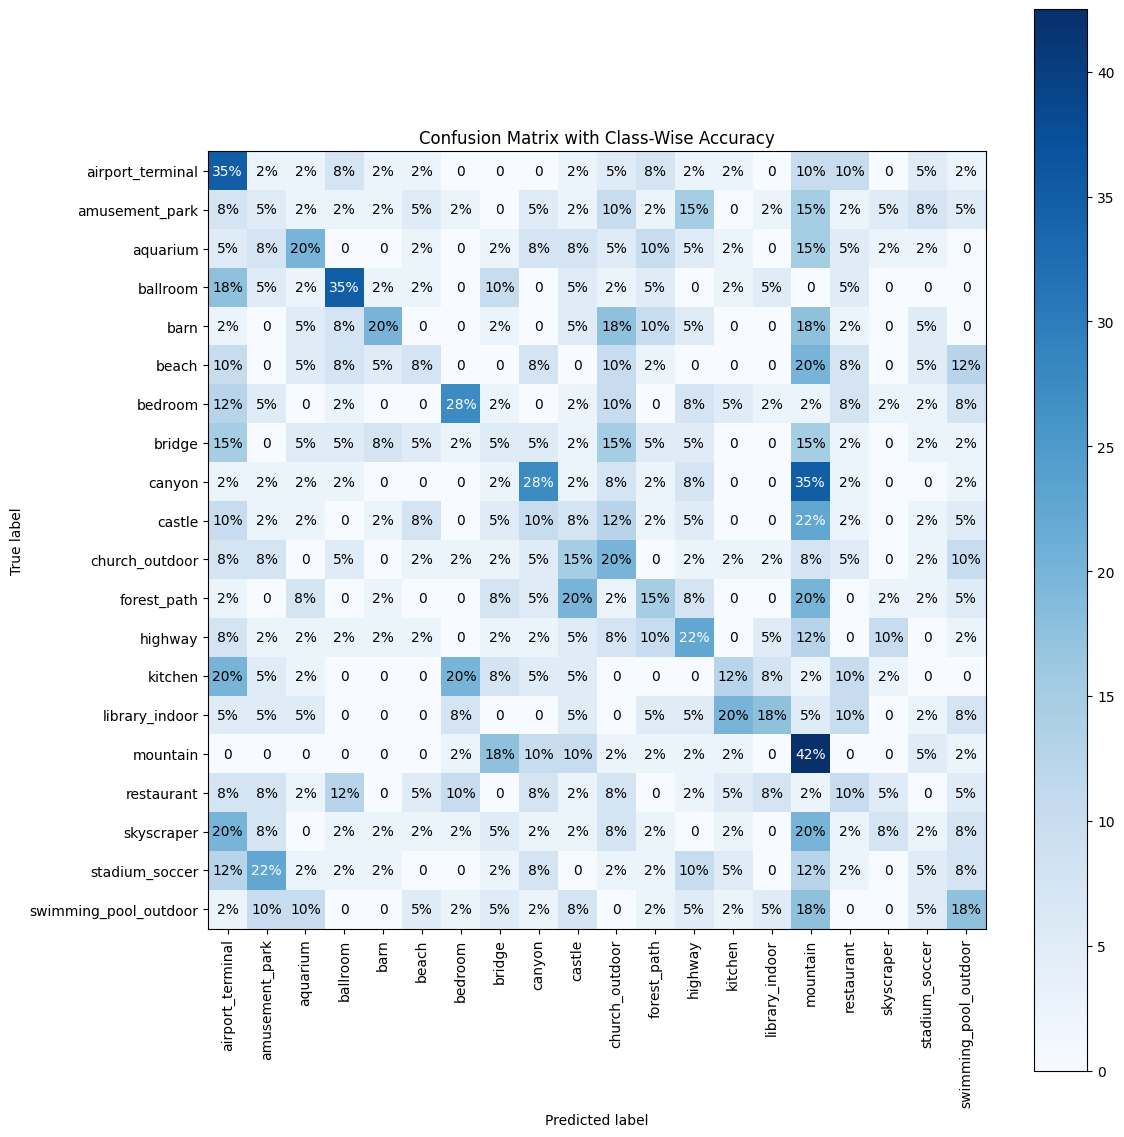

In [ ]:
effnet_model.eval()

all_predictions = []
all_labels = []

# To evaluate on the test set
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = effnet_model(images)
        _, predicted = torch.max(outputs, 1)

        # Store predictions and labels
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
class_names = test_loader.dataset.classes

cm_percentage = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100

annot = np.array([
    [f"{cm_percentage[i, j]:.0f}%" if cm[i, j] != 0 else "0" for j in range(len(class_names))]
    for i in range(len(class_names))
])

# Plot the confusion matrix
plt.figure(figsize=(12, 12))
plt.imshow(cm_percentage, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix with Class-Wise Accuracy")
plt.colorbar()

# class labels to axes
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)

for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, annot[i, j],
                 ha='center', va='center',
                 color='white' if cm[i, j] > cm.max() / 2 else 'black')

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

> For ResNet152x4

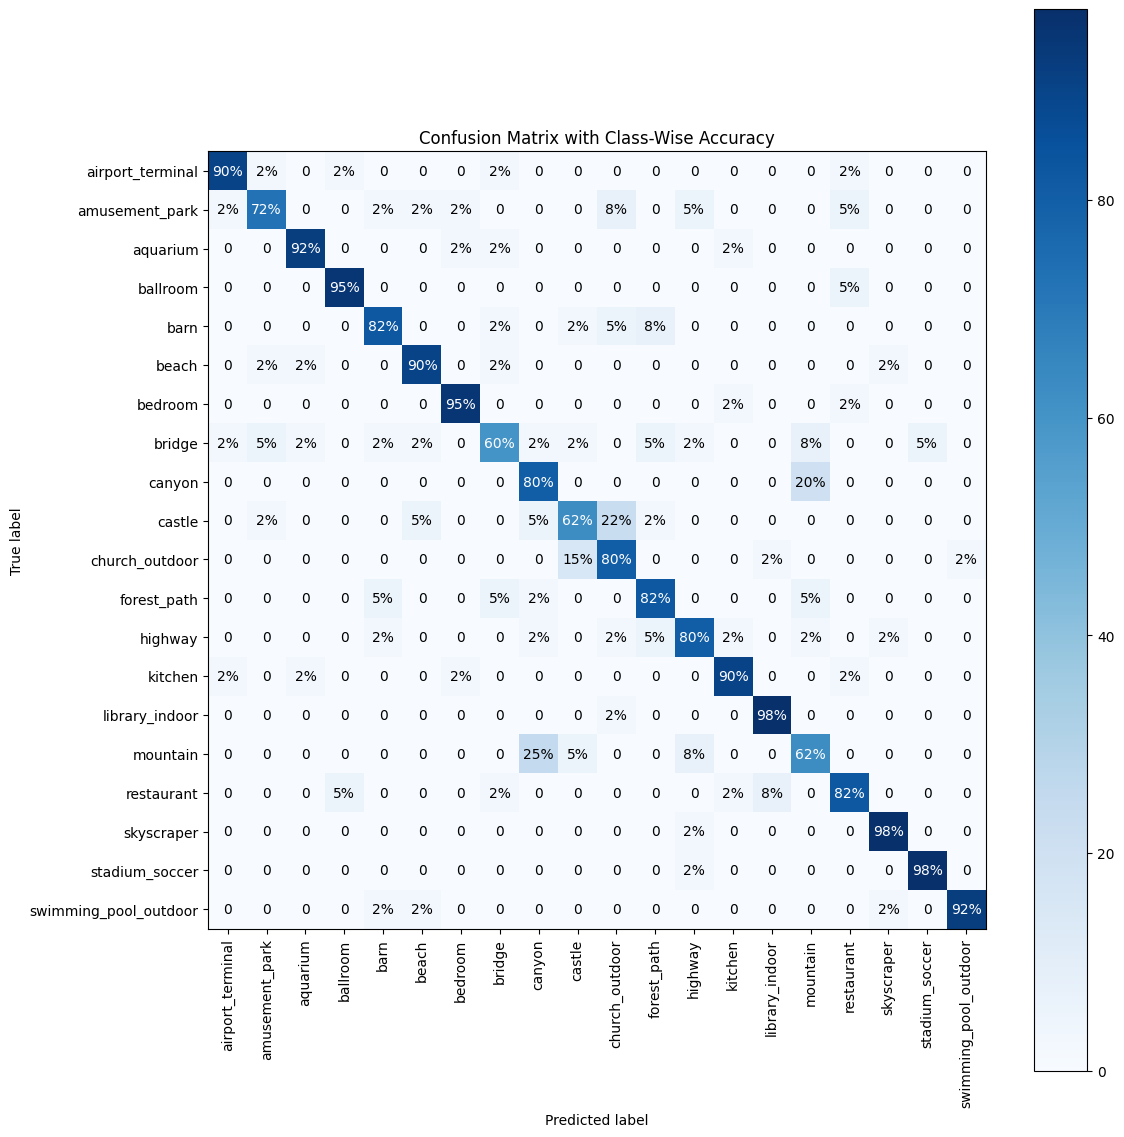

In [ ]:
resnet152x4.eval()

all_predictions = []
all_labels = []

# To evaluate on the test set
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = resnet152x4(images)
        _, predicted = torch.max(outputs, 1)

        # Store predictions and labels
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
class_names = test_loader.dataset.classes

cm_percentage = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100

annot = np.array([
    [f"{cm_percentage[i, j]:.0f}%" if cm[i, j] != 0 else "0" for j in range(len(class_names))]
    for i in range(len(class_names))
])

# Plot the confusion matrix
plt.figure(figsize=(12, 12))
plt.imshow(cm_percentage, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix with Class-Wise Accuracy")
plt.colorbar()

# class labels to axes
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)

for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, annot[i, j],
                 ha='center', va='center',
                 color='white' if cm[i, j] > cm.max() / 2 else 'black')

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()